# TASK 3: CUSTOMER CHURN PREDICTION
**Develop a model to predict customer churn for a subscription based service or business. Use historical customer data, including features like usage behavior and customer demographics, and try algorithms like Logistic Regression, Random Forests, or Gradient Boosting to predict churn.**

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
import warnings

# Suppressing warnings for cleaner output
warnings.filterwarnings("ignore")

In [3]:
# Setting a fixed random seed for reproducibility
np.random.seed(1000)

# Path to the dataset
file_path = 'Churn_Modelling.csv'

# Reading the dataset into a DataFrame
data = pd.read_csv(file_path)

# Checking the dimensions of the dataset
print(data.shape)

# Displaying the first few rows of the dataset
data.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Displaying the structure of the dataset
data.info()

# Displaying unique value counts for specific columns
unique_counts = data[['CustomerId', 'Surname', 'Geography', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'IsActiveMember', 'Exited']
].nunique().to_frame('Counts')
print(unique_counts.to_markdown())

# Checking for duplicate rows in the dataset
duplicate_rows = len(data[data.duplicated()])
print(f'Duplicate row counts: {duplicate_rows}')

# Summarizing null values in the dataset
null_summary = data.isnull().sum().to_frame('Null Counts')
null_summary['Total Records'] = len(data)
print(null_summary.to_markdown())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
|                |   Counts |
|:---------------|---------:|
| CustomerId     |    10000 |
| Su

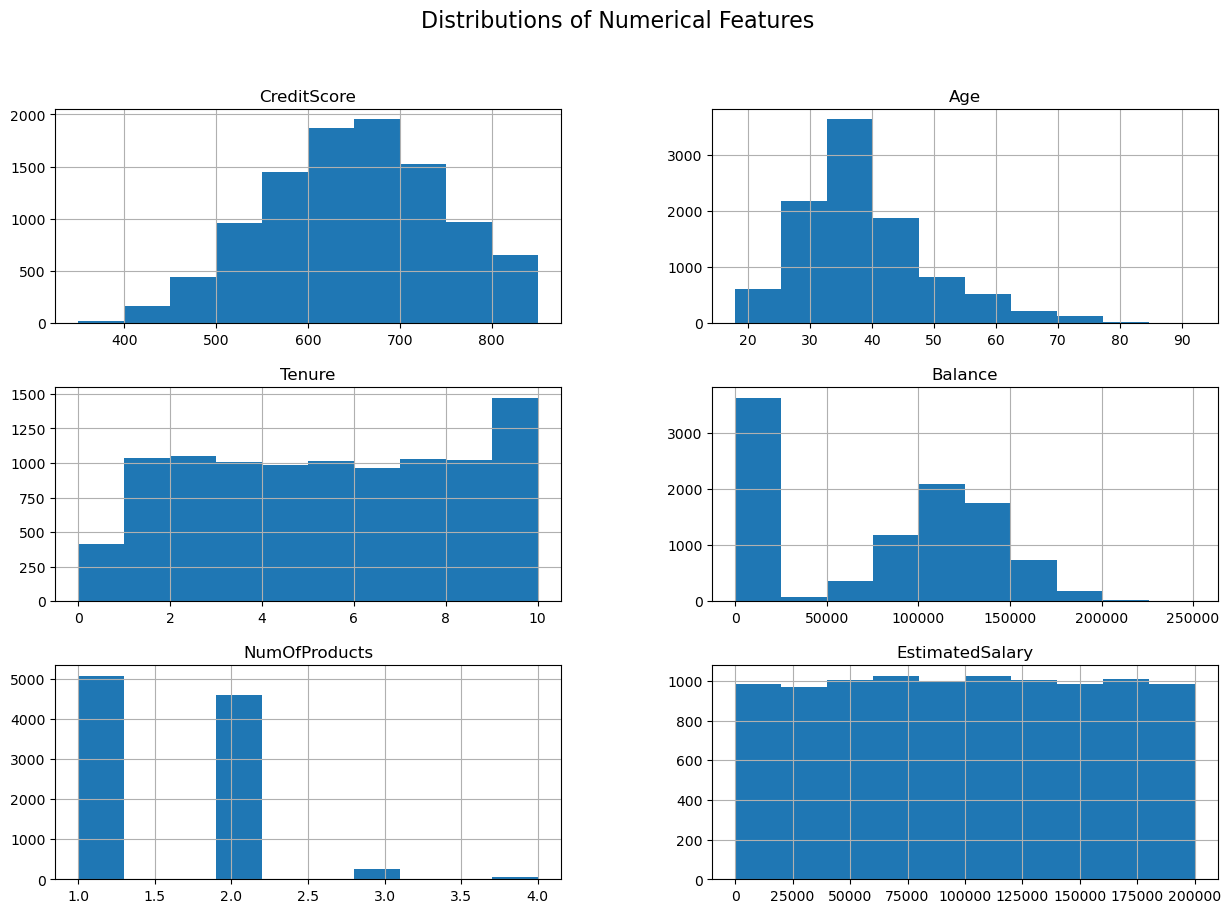

In [5]:
# Visualizations for numerical features
# Histograms
data.hist(column=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'], figsize=(15, 10))
plt.suptitle("Distributions of Numerical Features", fontsize=16)
plt.show()

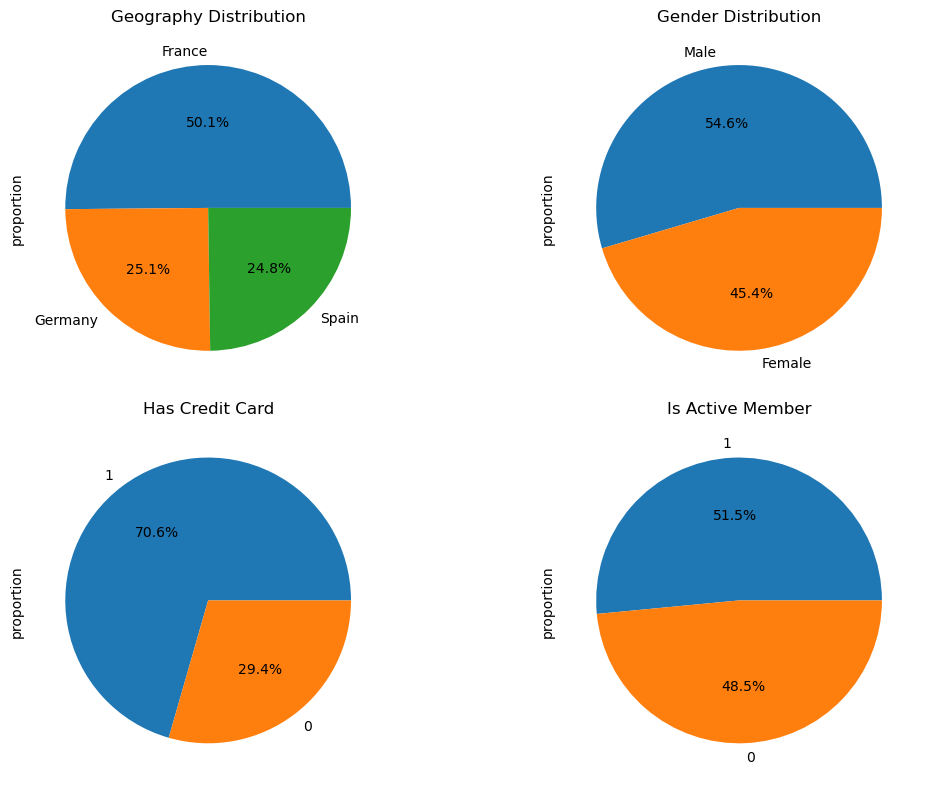

In [6]:
# Pie plots for categorical features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
data['Geography'].value_counts(normalize=True).plot.pie(ax=axes[0][0], autopct='%1.1f%%')
axes[0][0].set_title('Geography Distribution')

data['Gender'].value_counts(normalize=True).plot.pie(ax=axes[0][1], autopct='%1.1f%%')
axes[0][1].set_title('Gender Distribution')

data['HasCrCard'].value_counts(normalize=True).plot.pie(ax=axes[1][0], autopct='%1.1f%%')
axes[1][0].set_title('Has Credit Card')

data['IsActiveMember'].value_counts(normalize=True).plot.pie(ax=axes[1][1], autopct='%1.1f%%')
axes[1][1].set_title('Is Active Member')

plt.tight_layout()
plt.show()

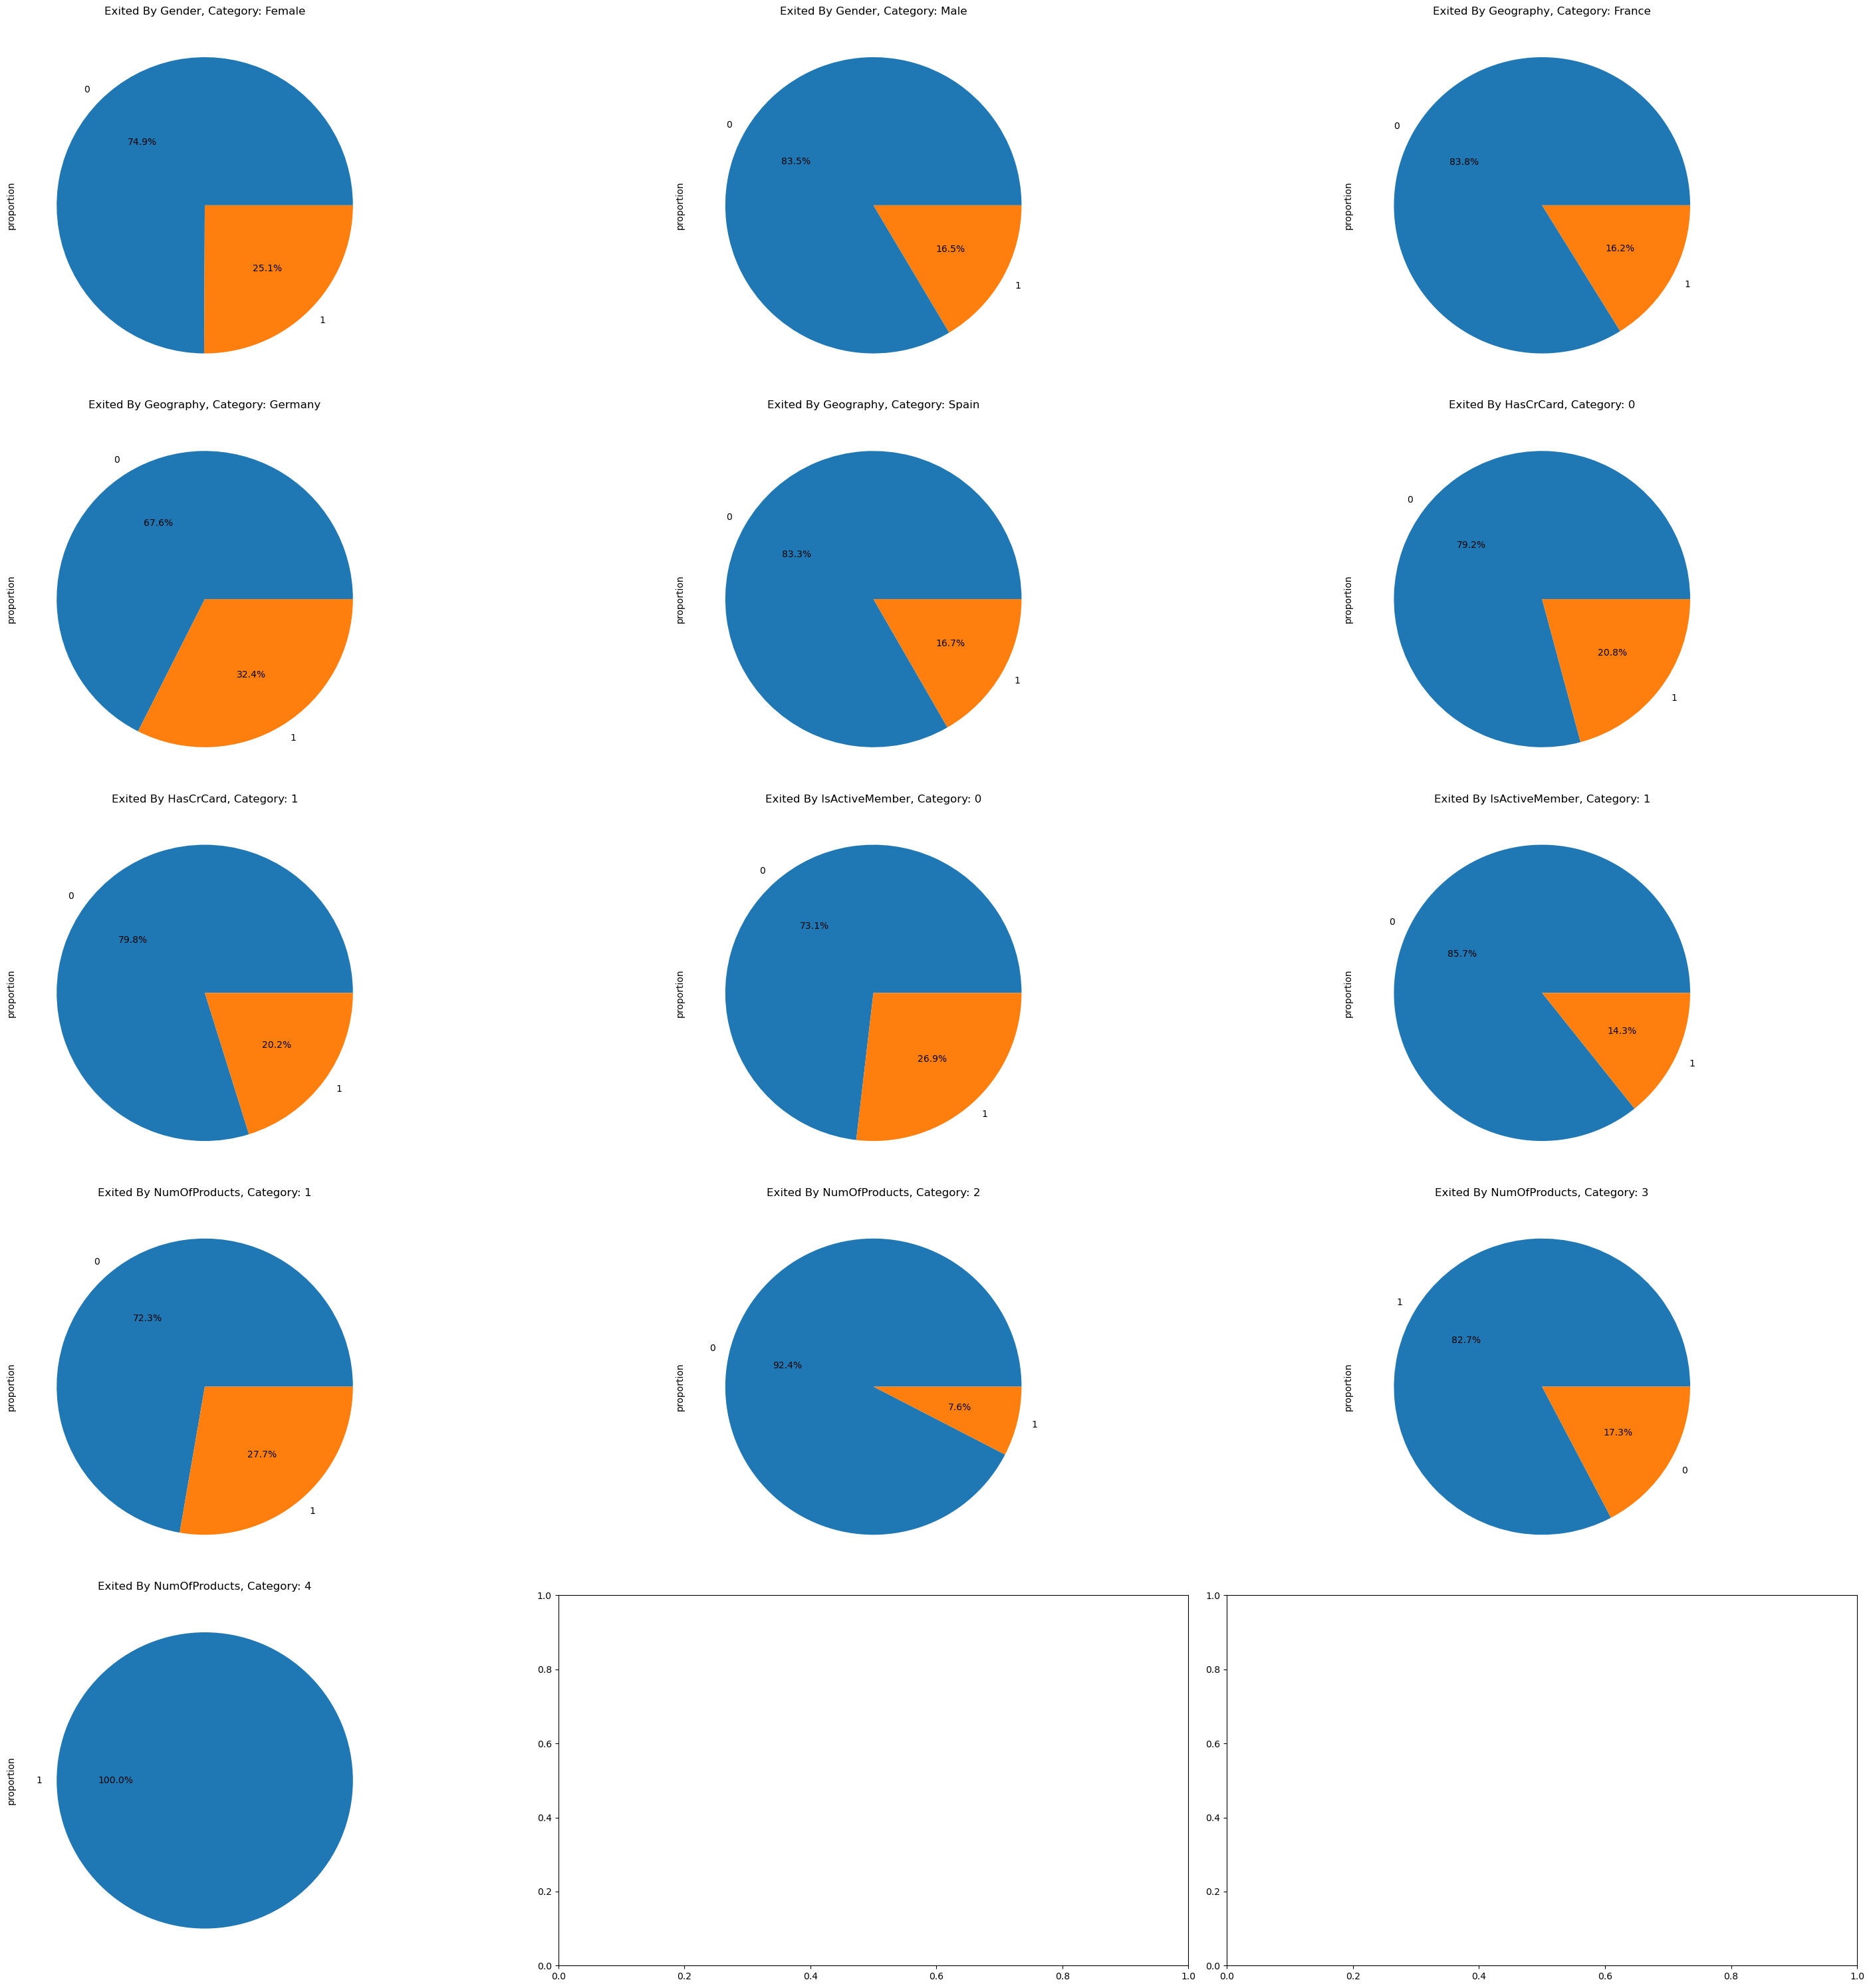

In [7]:
# Churn rate by category
key_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
combinations = sorted(
    [(col, key, group) for col in key_columns for key, group in data.groupby(col)],
    key=lambda x: (x[0], x[1])
)

fig, axes = plt.subplots((len(combinations) // 3) + 1, 3, figsize=(30, 30))
axes = axes.flatten()

for i, (col, key, group) in enumerate(combinations):
    group['Exited'].value_counts(normalize=True).plot.pie(ax=axes[i], autopct='%1.1f%%')
    axes[i].set_title(f'Exited By {col}, Category: {key}')

plt.tight_layout()
plt.show()

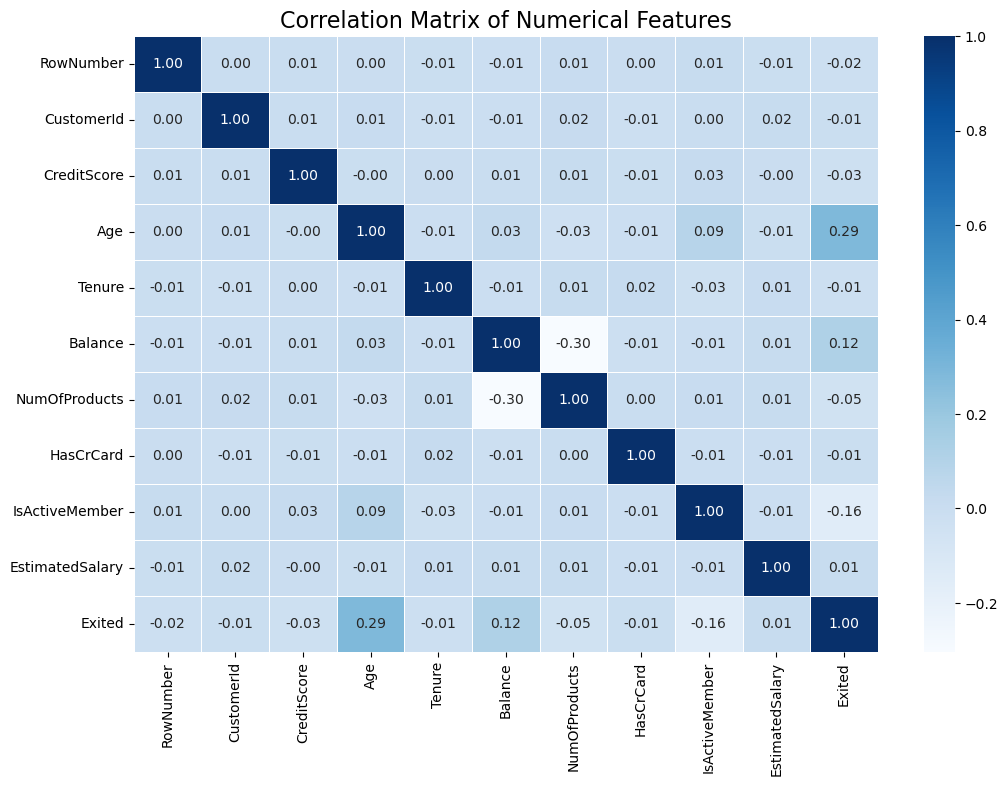

In [8]:
# Adding a correlation heatmap
# Selecting numerical columns for correlation analysis
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Calculating the correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", cbar=True, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.show()

In [9]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# --- Data Preparation ---
# Separate features (X) and target variable (y)
X = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)  # Exclude irrelevant columns
y = data['Exited']

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Geography', 'Gender'], drop_first=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# --- Feature Selection Methods ---

# --- Filter Method (SelectKBest) ---
print("\n--- Filter Method: SelectKBest ---")
selector_kbest = SelectKBest(score_func=f_classif, k=5)  # Select top 5 features
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)
X_test_kbest = selector_kbest.transform(X_test)

# Get selected feature names
selected_kbest_features = X.columns[selector_kbest.get_support()]
print("Top 5 features selected by SelectKBest:")
print(selected_kbest_features.tolist())


--- Filter Method: SelectKBest ---
Top 5 features selected by SelectKBest:
['Age', 'Balance', 'IsActiveMember', 'Geography_Germany', 'Gender_Male']


In [11]:
# --- Wrapper Method (RFE) ---
print("\n--- Wrapper Method: Recursive Feature Elimination (RFE) ---")
estimator = LogisticRegression(random_state=42)  # Use logistic regression as the estimator
selector_rfe = RFE(estimator, n_features_to_select=5)  # Select top 5 features
X_train_rfe = selector_rfe.fit_transform(X_train, y_train)
X_test_rfe = selector_rfe.transform(X_test)

# Get selected feature names
selected_rfe_features = X.columns[selector_rfe.get_support()]
print("Top 5 features selected by RFE:")
print(selected_rfe_features.tolist())


--- Wrapper Method: Recursive Feature Elimination (RFE) ---
Top 5 features selected by RFE:
['Age', 'Balance', 'IsActiveMember', 'Geography_Germany', 'Gender_Male']


In [12]:
# --- Embedded Method (Random Forest Feature Importance) ---
print("\n--- Embedded Method: Random Forest Feature Importance ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importances and sort them
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort features by importance in descending order

# Print feature rankings
print("Feature Ranking (Random Forest):")
for i in range(X.shape[1]):
    print(f"{i + 1}. {X.columns[indices[i]]} ({importances[indices[i]]:.6f})")

# Get top 5 important features
top_rf_features = X.columns[indices[:5]]
print("\nTop 5 features selected by Random Forest:")
print(top_rf_features.tolist())


--- Embedded Method: Random Forest Feature Importance ---
Feature Ranking (Random Forest):
1. Age (0.236922)
2. EstimatedSalary (0.147558)
3. CreditScore (0.143338)
4. Balance (0.141612)
5. NumOfProducts (0.131486)
6. Tenure (0.082080)
7. IsActiveMember (0.040725)
8. Geography_Germany (0.026190)
9. HasCrCard (0.018454)
10. Gender_Male (0.018421)
11. Geography_Spain (0.013214)

Top 5 features selected by Random Forest:
['Age', 'EstimatedSalary', 'CreditScore', 'Balance', 'NumOfProducts']


In [13]:
# --- Summary of Selected Features ---
print("\n--- Summary of Feature Selection Methods ---")
print(f"Filter Method (SelectKBest): {selected_kbest_features.tolist()}")
print(f"Wrapper Method (RFE): {selected_rfe_features.tolist()}")
print(f"Embedded Method (Random Forest): {top_rf_features.tolist()}")


--- Summary of Feature Selection Methods ---
Filter Method (SelectKBest): ['Age', 'Balance', 'IsActiveMember', 'Geography_Germany', 'Gender_Male']
Wrapper Method (RFE): ['Age', 'Balance', 'IsActiveMember', 'Geography_Germany', 'Gender_Male']
Embedded Method (Random Forest): ['Age', 'EstimatedSalary', 'CreditScore', 'Balance', 'NumOfProducts']


In [14]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# --- Data Preparation ---
# Separate features (X) and target variable (y)
X = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = data['Exited']

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Geography', 'Gender'], drop_first=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Model Training and Evaluation ---
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)  # probability=True for ROC AUC score
}

# Evaluate models using cross-validation
print("\n--- Cross-Validation Results ---")
cv_results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_results[name] = cv_scores.mean()
    print(f'{name}: Cross-validation accuracy = {cv_scores.mean():.4f}')


--- Cross-Validation Results ---
Logistic Regression: Cross-validation accuracy = 0.8104
Decision Tree: Cross-validation accuracy = 0.7835
Random Forest: Cross-validation accuracy = 0.8613
Gradient Boosting: Cross-validation accuracy = 0.8616
SVM: Cross-validation accuracy = 0.8545


In [15]:
# --- Hyperparameter Tuning (Random Forest Example) ---
print("\n--- Hyperparameter Tuning: Random Forest ---")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


--- Hyperparameter Tuning: Random Forest ---


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [16]:
# Retrieve the best model
best_rf_model = grid_search.best_estimator_
print(f'Best Random Forest hyperparameters: {grid_search.best_params_}')

Best Random Forest hyperparameters: {'max_depth': None, 'n_estimators': 300}


In [17]:
# --- Test Set Evaluation ---
print("\n--- Test Set Evaluation (Best Random Forest Model) ---")
y_pred = best_rf_model.predict(X_test)
y_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
print(f'ROC AUC: {roc_auc_score(y_test, y_proba):.4f}')


--- Test Set Evaluation (Best Random Forest Model) ---
Test Accuracy: 0.8690
Precision: 0.7695
Recall: 0.4758
F1-score: 0.5881
ROC AUC: 0.8633


In [18]:
# --- Summary ---
print("\n--- Model Comparison Summary ---")
for name, score in cv_results.items():
    print(f'{name}: Mean CV Accuracy = {score:.4f}')


--- Model Comparison Summary ---
Logistic Regression: Mean CV Accuracy = 0.8104
Decision Tree: Mean CV Accuracy = 0.7835
Random Forest: Mean CV Accuracy = 0.8613
Gradient Boosting: Mean CV Accuracy = 0.8616
SVM: Mean CV Accuracy = 0.8545
